В этом датасете собрана полная информация о различных ноутбуках, позволяющая детально проанализировать их технические характеристики и цены. В нем собраны ноутбуки различных марок, моделей и конфигураций.

Создайте модель, которая будет определять конечную цену ноутбука

#Введение

Подключение к диску, загрузка и установка необходимых библиотек

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Загрузка и исследование данных

Загружаю данные и посмотрю основную информацию о них

In [56]:
file_path = "/content/sample_data/laptops.csv"

df = pd.read_csv(file_path)

display(df)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3060,17.3,No,2699.99
2156,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3070,17.3,No,2899.99
2157,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,32,1000,SSD,RTX 3080,17.3,No,3399.99
2158,Razer Book 13 Intel Evo Core i7-1165G7/16GB/1T...,Refurbished,Razer,Book,Intel Evo Core i7,16,1000,SSD,NaN,13.4,Yes,1899.99


In [57]:
print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB
None
               RAM      Storage       Screen  Final Price
count  2160.000000  2160.000000  2156.000000  2160.000000
mean     15.413889   596.294444    15.168112  1312.638509
std       9.867815   361.220506     1.203329   9

In [58]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

##Общая информация о данных:

В датафрейме содержится информация о 2160 ноутбуках.
Присутствуют как числовые (RAM, Storage, Screen, Final Price), так и категориальные (Laptop, Status, Brand, Model, CPU, Storage type, GPU, Touch) признаки.
Видны пропущенные значения в столбцах Storage type и GPU.

**Анализ числовых признаков:**

Среднее значение RAM составляет около 15.41 ГБ, а Storage - около 596 ГБ.
Средний размер экрана около 15.17 дюйма.
Финальные цены варьируются от 201.05 до 7150.47, среднее значение составляет примерно 1312.64.

**Анализ категориальных признаков:**

Столбцы Laptop, Brand, Model, CPU, Storage type, GPU и Touch содержат различные категориальные значения.

***Пропущенные значения:***

В столбце Storage type есть некоторые пропущенные значения, которые могут потребоваться обработки.
В столбце GPU также есть много пропущенных значений, которые могут указывать на отсутствие дискретной графики в некоторых моделях ноутбуков.

#Предобработка данных:

Пропущенные значения в столбце Storage type заполню наиболее часто встречающимся значением (например, 'HDD' или 'SSD').
Пропущенные значения в столбце GPU можно заполнить значением 'None' для моделей без дискретной графики.
Категориальные признаки (кроме Touch) могут быть закодированы с помощью метода OneHotEncoding, который создаст бинарные признаки для каждой категории.

In [59]:
df.isnull().sum()

laptop             0
status             0
brand              0
model              0
cpu                0
ram                0
storage            0
storage_type      42
gpu             1371
screen             4
touch              0
final_price        0
dtype: int64

In [60]:
df['storage_type'].fillna('Unknown', inplace=True)
df['gpu'].fillna('Unknown', inplace=True)
df['screen'].fillna(df['screen'].median(), inplace=True)

In [61]:
df.isnull().sum()

laptop          0
status          0
brand           0
model           0
cpu             0
ram             0
storage         0
storage_type    0
gpu             0
screen          0
touch           0
final_price     0
dtype: int64

Пропуски обработаны

#Визуализация данных

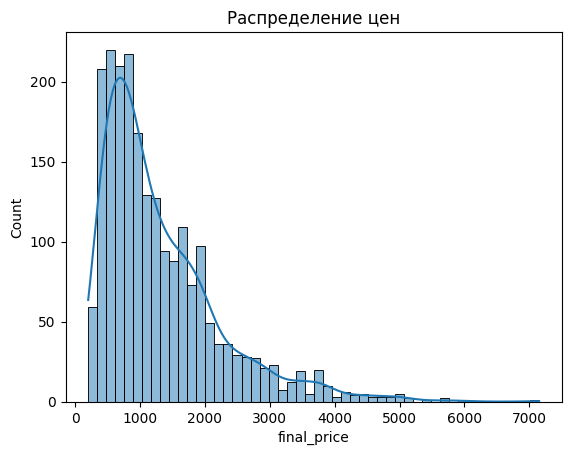

In [62]:
sns.histplot(df['final_price'], bins=50, kde=True)
plt.title('Распределение цен')
plt.show()

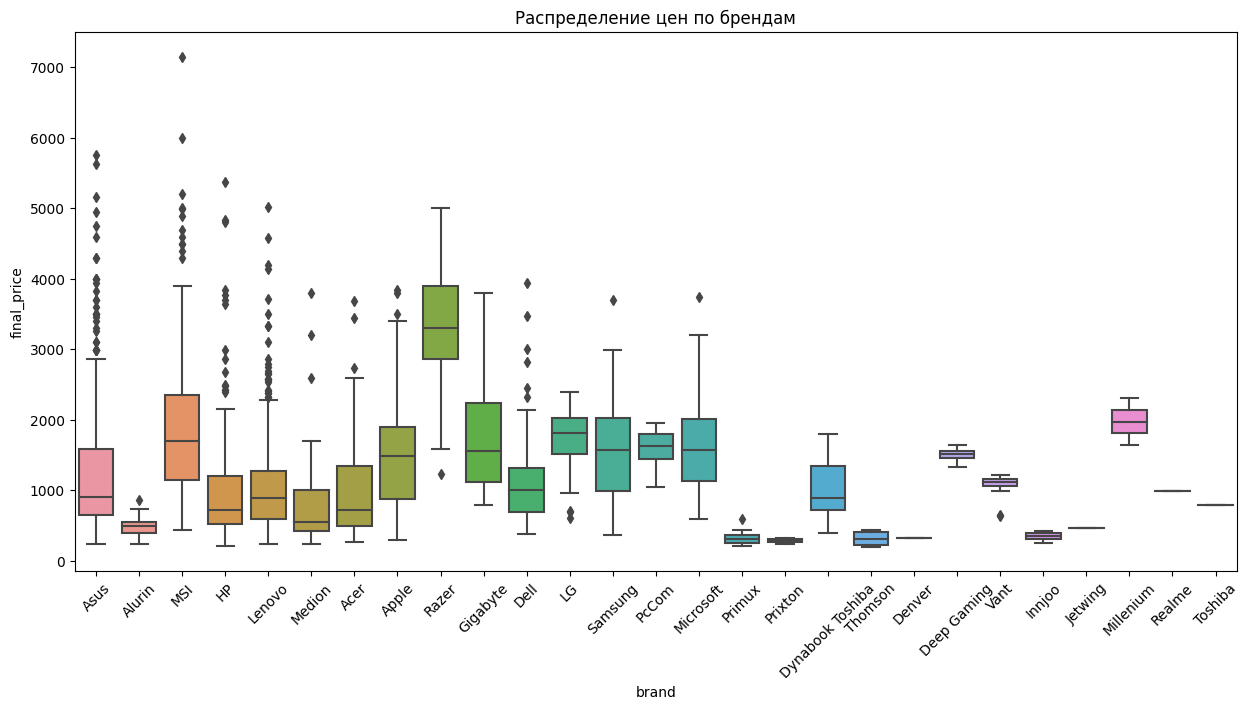

In [63]:
plt.figure(figsize=(15,7))
sns.boxplot(data=df, x='brand', y='final_price')
plt.xticks(rotation=45)
plt.title('Распределение цен по брендам')
plt.show()

**Вывод:**
1. Большинство цен на ноутбуки сосредоточено в ценовом сегменте до 2000$.
2. На ящике с ушами четко выделены основные производители, почти все они в среднем ценовом сегменте (кроме Razer и MSI).
3. На основе изученных данных можно выдвинуть гипотезы и проверить их.

В нашем случае целевой признак - это "Final Price", который представляет собой стоимость ноутбука в денежных единицах. Это непрерывная переменная, поскольку цена может принимать любое значение в определенном диапазоне. Задача заключается в том, чтобы, основываясь на различных характеристиках ноутбука (как, например, объем RAM, бренд, объем хранения и другие), предсказать его стоимость.

#Подготовка и обучение модели

Перед обучением необходимо произвести кодирование признаков. Выполню через One-Hot Encoding и подготовлю данные к обучение

In [64]:
df = pd.get_dummies(df, columns=['laptop', 'status', 'brand', 'model', 'cpu', 'storage_type', 'gpu', 'touch'], drop_first=True)

# Проверим, как теперь выглядит DataFrame
df.columns

Index(['ram', 'storage', 'screen', 'final_price',
       'laptop_ASUS BR1100FKA-BP1185XA Intel Celeron N4500/4GB/128GB SSD/11.6" Táctil',
       'laptop_ASUS Chromebook C433TA-AJ0336 Intel Core m3-8100Y/8GB/64GB eMMC/14" Táctil',
       'laptop_ASUS Chromebook CR1 CR1100CKA-GJ0132 Intel Celeron N4500/4GB/32GB/11.6"',
       'laptop_ASUS Chromebook CR1100FKA-BP0024 Intel Celeron N4500/4GB/32GB eMMC/11.6" Táctil',
       'laptop_ASUS Chromebook CX1400CKA-EK0138 Intel Celeron N4500/8GB/64GB eMMC/14"',
       'laptop_ASUS Chromebook CX1400CNA-BV0210 Intel Celeron N3350/8GB/32GB/14"',
       ...
       'gpu_Radeon Pro RX 560X', 'gpu_Radeon RX 6600M', 'gpu_T 1000',
       'gpu_T 1200', 'gpu_T 2000', 'gpu_T 500', 'gpu_T 550', 'gpu_T 600',
       'gpu_Unknown', 'touch_Yes'],
      dtype='object', length=2384)

##Разделение данных на выборки

In [65]:
# Отделяем целевую переменную от признаков
X = df.drop('final_price', axis=1)
y = df['final_price']

# Разделяем выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Разделяем выборку на валидационную и тестовую
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Данные разделены на выборки

Признаки масштабированы, теперь обосную выбор метрики

Для проекта, который направлен на прогнозирование цены ноутбуков (задача регрессии), важна легкая интерпретируемость метрики (например, для объяснения результатов неспециалистам), поэтому MAE или RMSE могут быть более предпочтительными.

Соответственно, буду использовать RMSE, поскольку основная цель — точно предсказывать цены, включая редкие, но значительные отклонения (например, очень дорогие модели).

Учитывая, что цены на ноутбуки могут сильно варьироваться и наличие дорогих моделей может существенно влиять на точность предсказания, RMSE может быть наиболее подходящей метрикой для проекта.

**Случайный лес (Random Forest)**

In [66]:
# Диапазоны параметров для случайного леса
rf_params = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(5, 25),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3)
}

# Настройка RandomizedSearchCV
rf_search = RandomizedSearchCV(RandomForestRegressor(), rf_params,
                               n_iter=10, scoring='neg_root_mean_squared_error',
                               random_state=42, n_jobs=-1)

# Запуск поиска
rf_search.fit(X_train, y_train)

# Лучшие параметры и RMSE
rf_best_params = rf_search.best_params_
rf_best_rmse = -rf_search.best_score_
print(f"Лучшие параметры RandomForest: {rf_best_params}")
print(f"Лучшие параметры RandomForest для (RMSE): {rf_best_rmse}")

Лучшие параметры RandomForest: {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 64}
Лучшие параметры RandomForest для (RMSE): 398.50178368696686
